# Мощности критериев

In [70]:
%matplotlib inline
import math
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from functools import partial

## task1

Мощность для критерия колмогорова:

In [270]:
def kg_power_t1(n, *, tetta1, tetta2, sigmasq=1, eps=0.05):
    X = np.array([ss.kstest(partial(ss.norm.rvs, loc=tetta2, scale=math.sqrt(sigmasq)),
                            partial(ss.norm.cdf, loc=tetta1, scale=math.sqrt(sigmasq)), N=n)[1] 
                  for _ in range(int(n / eps))])
    return (X <= eps).sum() / len(X)


kg_power_t1(500, tetta1=0, tetta2=0.25)

0.99850000000000005

Рассмотрим критерий Пирсона для первой задачи. Посчитаем вероятность ошибки второго рода при верной второй гипотезе. Логарифмируем отношение под вероятностью (бпо, $\theta_2 > \theta_1$):
$$-\frac{(\theta_2 - \theta_1)}{2 \sigma^2} \sum\limits_{i=1}^{n}{(\theta_1 + \theta_2 - 2x_i)} \leqslant \log(C)$$
$$\frac{(\theta_2 - \theta_1)}{\sigma^2} \sum\limits_{i=1}^{n}{x_i} \leqslant \log(C) + \frac{n (\theta_2 - \theta_1) (\theta_2 + \theta_1)}{2 \sigma^2}$$
$$\sum\limits_{i=1}^{n}{x_i} \leqslant \frac{\log(C) \sigma^2}{(\theta_2 - \theta_1)} + \frac{n (\theta_2 + \theta_1)}{2}$$
А сумма нормальных случайных величин - нормальная случайная величина. Надо найти $C$ при заданном $\epsilon$:
$$P_{H_1}(\sum\limits_{i=1}^{n}{x_i} \geqslant \frac{\log(C) \sigma^2}{(\theta_2 - \theta_1)} + \frac{n (\theta_2 + \theta_1)}{2}) = \epsilon$$
А это квантиль нормального распределения (заодно мы нашли $\frac{\log(C) \sigma^2}{(\theta_2 - \theta_1)} + \frac{n (\theta_2 + \theta_1)}{2}$):

In [253]:
def np_power_t1(n, *, tetta1, tetta2, sigmasq=1, eps=0.05):
    if tetta2 > tetta1:
        x = ss.norm.isf(eps, loc=n * tetta1, scale=math.sqrt(n * sigmasq))
        A = ss.norm.cdf(x, loc=n * tetta2, scale=math.sqrt(n * sigmasq))
    else:
        x = ss.norm.ppf(eps, loc=n * tetta1, scale=math.sqrt(n * sigmasq))
        A = ss.norm.sf(x, loc=n * tetta2, scale=math.sqrt(n * sigmasq))
    return 1 - A


np_power_t1(500, tetta1=0, tetta2=0.25)

0.99996015264797433

Строим графики:

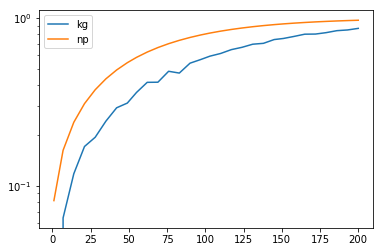

In [269]:
tetta1, tetta2 = 0, 0.25
k = 30
X = np.linspace(1, 200, num=k).astype(np.int)
plt.plot(X, [kg_power_t1(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="kg")
plt.plot(X, [np_power_t1(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="np")
plt.legend()
plt.yscale("log")

## task2

Мощность для критерия колмогорова:

In [278]:
def kg_power_t2(n, *, tetta1, tetta2, eps=0.05):
    X = np.array([ss.kstest(partial(ss.expon.rvs, scale=1 / tetta2),
                            partial(ss.expon.cdf, scale=1 / tetta1), N=n)[1] 
                  for _ in range(int(n / eps))])
    return (X <= eps).sum() / len(X)


kg_power_t2(50, tetta1=0.5, tetta2=1)

0.98899999999999999

Аналогично первой задаче, получаем:
$$\sum\limits_{i=1}^{n}{x_i} \leqslant \frac{\log(C) - n \log{\frac{\theta_2}{\theta_1}}}{\theta_1 - \theta_2}$$
Величина слева распределена согласно Гамма распределению. Проделываем тот же трюк:

In [281]:
def np_power_t2(n, *, tetta1, tetta2, eps=0.05):
    if tetta1 > tetta2:
        x = ss.gamma.isf(eps, a=n, scale=1 / tetta1)
        A = ss.gamma.cdf(x, a=n, scale=1 / tetta2)
    else:
        x = ss.gamma.ppf(eps, a=n, scale=1 / tetta1)
        A = ss.gamma.sf(x, a=n, scale=1 / tetta2)
    return 1 - A


np_power_t2(50, tetta1=0.5, tetta2=1)

0.99970220447453428

Строим графики:

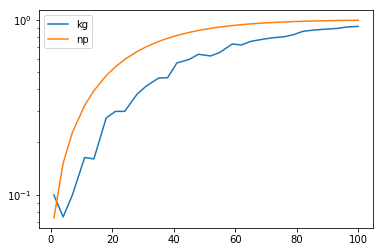

In [284]:
tetta1, tetta2 = 0.5, 0.75
k = 30
X = np.linspace(1, 100, num=k).astype(np.int)
plt.plot(X, [kg_power_t2(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="kg")
plt.plot(X, [np_power_t2(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="np")
plt.legend()
plt.yscale("log")

## task3

Мощность для критерия хи-2:

In [352]:
def k2_power_t3(n, *, tetta1, tetta2, eps=0.05):
    f_exp, m, prev, points, k = [], n, 0, [], 0
    while True:
        k += 1
        this = ss.poisson.cdf(k, mu=tetta1)
        t = int(round((this - prev) * n))
        m -= t
        prev = this
        if t != 0:
            points.append(k)
            f_exp.append(t)
        else:
            break
    else:
        f_exp.append(m)
    points = points[:-1]
    p_values = []
    for _ in range(int(n / eps)):
        X = ss.poisson.rvs(mu=tetta2, size=n)
        f_obs, total = [], 0
        for k in points:
            this = (X <= k).sum()
            f_obs.append(this - total)
            total = this
        f_obs.append(len(X) - total)
        p_values.append(ss.chisquare(f_obs, f_exp)[1])
    p_values = np.array(p_values)
    return (p_values <= eps).sum() / len(p_values)


k2_power_t3(100, tetta1=1, tetta2=1.5)

0.97499999999999998

Аналогично первым двум, получаем:

In [346]:
def np_power_t3(n, *, tetta1, tetta2, eps=0.05):
    if tetta2 > tetta1:
        x = ss.poisson.isf(eps, mu=n * tetta1)
        A = ss.poisson.cdf(x, mu=n * tetta2)
    else:
        x = ss.poisson.ppf(eps, mu=n * tetta1)
        A = ss.poisson.sf(x, mu=n * tetta2)
    return 1 - A


np_power_t3(100, tetta1=1, tetta2=1.5)

0.99697563626377983

И граффики:

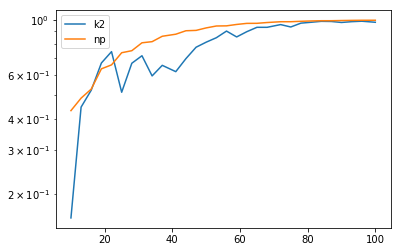

In [354]:
tetta1, tetta2 = 1, 1.5
k = 30
X = np.linspace(10, 100, num=k).astype(np.int)
plt.plot(X, [k2_power_t3(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="k2")
plt.plot(X, [np_power_t3(x, tetta1=tetta1, tetta2=tetta2) for x in X], label="np")
plt.legend()
plt.yscale("log")

## final words
Как видно на всех трех графиках - мощность критерия Неймана-Пирсона больше, чем у остальных критериев.